In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [87]:
def str_to_float(number):
    '''
    Cette fonction permet de convertir un string en float
    Ex : '1234,56' -> 1234.56
    '''
    num = number.split(',')
    if len(num)==1 :
        return float(num[0])
    else :
        return (float(num[0]+'.'+num[1]))

str_to_float_v = np.vectorize(str_to_float) # Vectorisation de la fonction str_to_float

def time_to_float(ts):
    return sum(float(x) * 60 ** i for i, x in enumerate(reversed(ts.split(':'))))

time_to_float_v = np.vectorize(time_to_float) # Vectorisation de la fonction time_to_float

In [49]:
def new_name(path,ext):
    '''
    Cette fonction permet de renommer un fichier en changeant son extension
    Ex : 'C:\\Users\\user\\Desktop\\data.csv' -> 'C:\\Users\\user\\Desktop\\data.png'
    '''
    componants = path.split("\\")
    name = componants[-1]
    name2 = name[:-4]
    return (name2 + "." + ext)

In [88]:
def create_data(path,n,data_type = 'value'):
    '''
    Cette fonction retourne les données d'un fichier csv
    Elle retroune les données de la colonne n
    '''
    data = pd.read_csv(path, index_col="Bal", delimiter=";")
    columns = data.columns
    data_to_plot = columns[n]
    if data_type == 'value':
        val = str_to_float_v(data[data_to_plot].values)
    elif data_type == 'time':
        val = time_to_float_v(data[data_to_plot].values)
    x = np.arange(0,len(val))
    return x,data_to_plot,val

In [51]:
def plot_csv(path):
    '''
    Cette fonction permet de tracer les données d'un fichier csv
    '''
    x,data_to_plot,val = create_data(path,2) # Récupération des données

    plt.figure()
    plt.plot(val)
    plt.xlabel("Balayage")
    plt.ylabel(data_to_plot)
    plt.grid()
    plt.savefig('Plot\\'+new_name(path,'png'))
    plt.show()

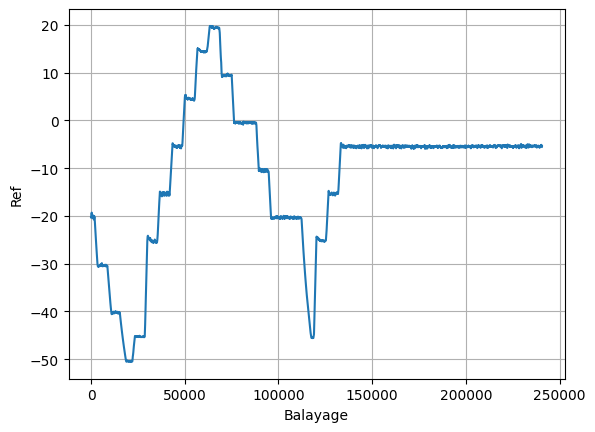

In [93]:
plot_csv("Data\\refPVT.csv")

In [90]:
def detect_stable_stage(path, precision=0.1, window_size=100, plot=False) :
    '''
    Cette fonction permet de détecter les paliers stables d'un fichier csv
    Elle retourne une matrice de taille (nb_stages,4) avec :
    - La première colonne : le début du palier (en numéro de balayage)
    - La deuxième colonne : la fin du palier (en numéro de balayage)
    - La troisième colonne : le début du palier (en temps)
    - La quatrième colonne : la fin du palier (en temps)
    - La cinquième colonne : la moyenne du palier
    - La sixième colonne : la variance du palier

    path : chemin du fichier csv
    precision : seuil de la variance pour détecter un palier
    window_size : taille de la fenêtre de calcul de la variance
    plot : booléen pour afficher le graphe de la variance
    '''
    x,data_to_plot,values = create_data(path,2) # Récupération des données
    x,data_to_plot,times = create_data(path,1,data_type='time') # Récupération des données

    n = len(values)
    variances = np.empty(n-window_size) # tableau des variances
    means = np.empty(n-window_size) # tableau des moyennes
    
    for i in range(n - window_size):
        window_data = values[i:i+window_size] # fenêtre de données
        var = np.var(window_data)
        mean = np.mean(window_data)
        variances[i] = var
        means[i] = mean
        
    points_stage = np.where(variances < precision)[0] 
    points_stage_by_stage = np.split(points_stage, np.where(np.diff(points_stage) != 1)[0]+1) # séparation des paliers
    nb_stages = len(points_stage_by_stage) # nombre de paliers

    stages_matrix = np.empty((nb_stages,6)) # matrice des paliers
    stages_matrix[:,0] = list(map(min,points_stage_by_stage))
    stages_matrix[:,1] = list(map(max,points_stage_by_stage))
    stages_matrix[:,2] = times[stages_matrix[:,0].astype(int)]
    stages_matrix[:,3] = times[stages_matrix[:,1].astype(int)]
    stages_matrix[:,4] = means[stages_matrix[:,0].astype(int)]
    stages_matrix[:,5] = variances[stages_matrix[:,0].astype(int)]

    if plot :
        plt.plot(variances)
        plt.plot([precision]*(n-window_size),'r')
    return stages_matrix

array([[ 0.00000000e+00,  2.86290000e+04,  6.55560000e+04,
         1.77460000e+04, -2.03370100e+01,  2.01376990e-03],
       [ 3.00080000e+04,  3.55660000e+04,  1.96070000e+04,
         2.71110000e+04, -2.49221200e+01,  4.93803256e-02],
       [ 3.56560000e+04,  3.56980000e+04,  2.72330000e+04,
         2.72890000e+04, -2.27749900e+01,  4.97997099e-02],
       [ 3.61270000e+04,  3.61480000e+04,  2.78690000e+04,
         2.78980000e+04, -1.89486100e+01,  4.98531779e-02],
       [ 3.62920000e+04,  3.64490000e+04,  2.80920000e+04,
         2.83040000e+04, -1.75862200e+01,  4.97603516e-02],
       [ 3.65590000e+04,  4.27020000e+04,  2.84530000e+04,
         3.67620000e+04, -1.56311400e+01,  4.99817404e-02],
       [ 4.27970000e+04,  4.29770000e+04,  3.68900000e+04,
         3.71340000e+04, -9.03047000e+00,  4.97167691e-02],
       [ 4.31100000e+04,  4.89200000e+04,  3.73140000e+04,
         4.51870000e+04, -6.60039000e+00,  4.98497179e-02],
       [ 4.90390000e+04,  4.91110000e+04,  4.534

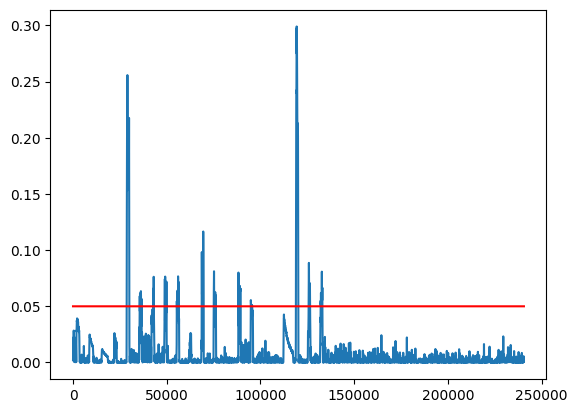

In [98]:
detect_stable_stage("Data\\refPVT.csv",precision=0.05,window_size=100,plot=True)

In [100]:
def stables_stage_csv(path, precision=0.1, window_size=100):
    '''
    Cette fonction permet de détecter les paliers stables d'un fichier csv
    Elle retourne une dataframe de taille (nb_stages,4) avec :
    - La première colonne : le début du palier
    - La deuxième colonne : la fin du palier
    - La troisième colonne : la moyenne du palier
    - La quatrième colonne : la variance du palier
    '''
    stages_matrix = detect_stable_stage(path, precision, window_size)
    nb_stages = len(stages_matrix)
    ind = np.arange(nb_stages)
    df = pd.DataFrame(stages_matrix, index=ind, columns=['Debut (Bal)','Fin (Bal)','Debut (Temps)','Fin (Temps)','Moyenne','Variance'])
    df.to_csv('Plot\\mat_'+new_name(path,'csv'))
    return df

In [102]:
stables_stage_csv("Data\\refPVT.csv",precision=0.05,window_size=100)

,Debut (Bal),Fin (Bal),Debut (Temps),Fin (Temps),Moyenne,Variance
0,0.0,28629.0,65556.0,17746.0,-20.33701,0.002014
1,30008.0,35566.0,19607.0,27111.0,-24.92212,0.049380
2,35656.0,35698.0,27233.0,27289.0,-22.77499,0.049800
3,36127.0,36148.0,27869.0,27898.0,-18.94861,0.049853
4,36292.0,36449.0,28092.0,28304.0,-17.58622,0.049760
5,36559.0,42702.0,28453.0,36762.0,-15.63114,0.049982
6,42797.0,42977.0,36890.0,37134.0,-9.03047,0.049717
7,43110.0,48920.0,37314.0,45187.0,-6.60039,0.049850
8,49039.0,49111.0,45348.0,45446.0,-2.39059,0.049444
9,49255.0,49272.0,45641.0,45664.0,-0.60827,0.049940


In [57]:
def stables_stage_list(path, precision=0.1, window_size=100):
    '''
    Cette fonction donne les paliers stables d'un fichier csv sous forme de liste
    Elle retourne une liste de taille (nb_stages,2) avec :
    - La première colonne : la durée du palier
    - La deuxième colonne : la moyenne du palier
    '''
    stages_matrix = detect_stable_stage(path, precision, window_size)
    duree = stages_matrix[:,1] - stages_matrix[:,0]
    mean = stages_matrix[:,2]
    return list(zip(duree,mean))

In [58]:
stables_stage_list("Data\debit.csv",precision=0.05,window_size=10)

[(202.0, 19.999900000000004),
 (48.0, 17.002299999999998),
 (29.0, 14.0007),
 (13.0, 11.0045),
 (19.0, 8.0016),
 (31.0, 5.0024),
 (44.0, 2.0035),
 (30.0, 2.9851),
 (18.0, 1.0440999999999998),
 (386.0, 1.9974999999999998),
 (27.0, 3.9997)]

In [59]:
def polynomial_interpolation(x, y, degree):
    '''
    Cette fonction permet de faire une interpolation polynomiale
    Elle retourne le polynome d'interpolation
    '''
    poly = np.polynomial.polynomial.Polynomial.fit(x, y, degree)
    return poly

In [60]:
x,name,y1 = create_data("Data\Sondes.csv",2)
p = polynomial_interpolation(x,y1,3)
print(p)
p(2)

103.536497862893 - 58.22535331118994 x**1 - 83.02168324560908 x**2 +
69.20267464299194 x**3


9.727232161257177

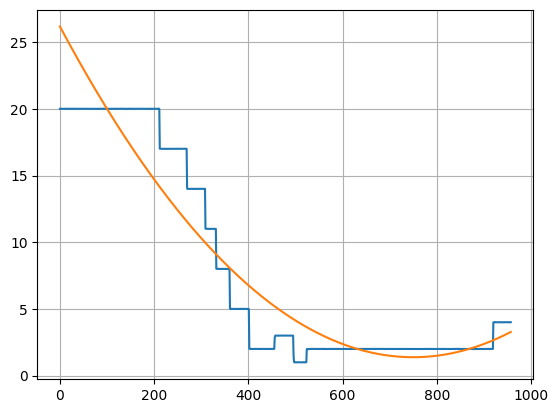

In [61]:
x,name,y = create_data("Data\debit.csv",2)
plt.figure()
x_corrected = x[0:60000]
y_corrected = y[0:60000]
plt.plot(x_corrected,y_corrected)
p = polynomial_interpolation(x_corrected,y_corrected,2)
z = p(x_corrected)
plt.plot(x_corrected,z)
plt.grid()
plt.show()


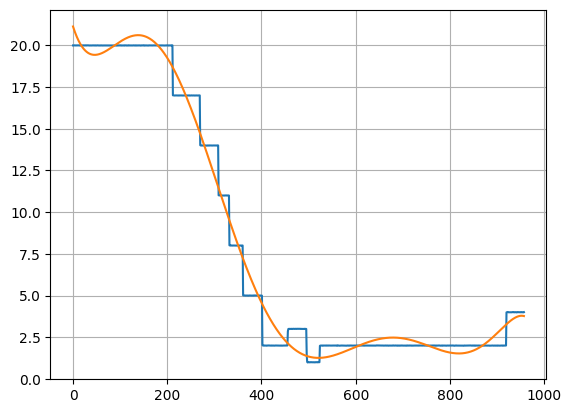

In [62]:
x,name,y = create_data("Data\debit.csv",2)
plt.figure()
plt.plot(x,y)
p = polynomial_interpolation(x,y,8)
z = p(x)
plt.plot(x,z)
plt.grid()
plt.show()

In [63]:
def linear_interpolation(x, y):
    """Interpolate a linear function through the given points.
    """
    coeffs = np.polyfit(x, y, 1)
    return np.poly1d(coeffs)

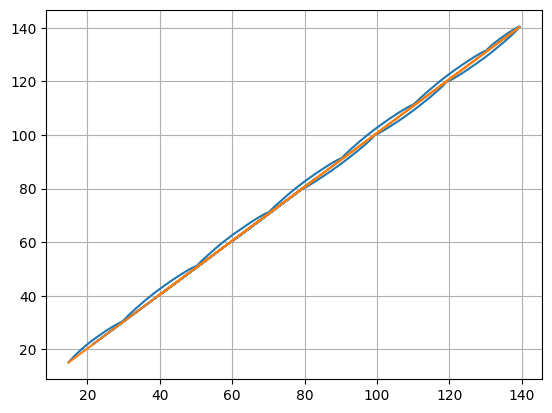

poly1d([1.00464052, 0.26981523])

In [86]:
def comparaison_sondes(n1,n2, graph = True):
    '''
    Cette fonction permet de comparer les sondes n1 et n2
    Elle retourne un graphe de comparaison si nécessaire
    '''
    x,name,y1 = create_data("Data\Sondes.csv",n1)
    x,name,y2 = create_data("Data\Sondes.csv",n2)
    p = linear_interpolation(y1,y2)
    z = p(y1)
    if graph :
        plt.figure()
        plt.plot(y1,y2)
        plt.plot(y1,z)
        plt.grid()
        plt.show()
    return p

p = comparaison_sondes(2,3)
p